In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import confusion_matrix
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import os
import time
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold,GroupKFold,StratifiedKFold
import copy
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve ,precision_recall_curve
from sklearn.metrics import f1_score
import random
import gc

%matplotlib inline

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
#df = reduce_mem_usage(pd.read_csv('/content/drive/My Drive/fraudremove/train.csv'))
#df_test = reduce_mem_usage(pd.read_csv('/content/drive/My Drive/fraudremove/test.csv'))
df_sortprob = reduce_mem_usage(pd.read_csv('df_sortprob.csv'))
df = reduce_mem_usage(pd.read_csv('train.csv'))
df_test = reduce_mem_usage(pd.read_csv('test.csv'))

Memory usage of dataframe is 174.15 MB
Memory usage after optimization is: 49.34 MB
Decreased by 71.7%
Memory usage of dataframe is 267.04 MB
Memory usage after optimization is: 60.95 MB
Decreased by 77.2%
Memory usage of dataframe is 70.78 MB
Memory usage after optimization is: 16.49 MB
Decreased by 76.7%


In [4]:
seed = 42
np.random.seed(seed)
random.seed(seed)

In [5]:
def show_cor(df1):
    plt.figure(figsize = (20,20))
    df_corr = df1.corr()
    sns.heatmap(df_corr,fmt = '0.2f',annot = True,xticklabels=df_corr.columns,yticklabels=df_corr.columns,cmap="Reds")
    plt.show()

In [6]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(train_df, test_df, columns, self_encoding=False):
    for col in columns:
        temp_df = pd.concat([train_df[[col]], test_df[[col]]])
        fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
        if self_encoding:
            train_df[col] = train_df[col].map(fq_encode)
            test_df[col]  = test_df[col].map(fq_encode)            
        else:
            train_df[col+'_FE'] = train_df[col].map(fq_encode)
            #print(train_df[col+'_FE'].sort_index().head())
            test_df[col+'_FE']  = test_df[col].map(fq_encode)
    return train_df, test_df
#encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])

In [7]:
# LABEL ENCODE
def encode_LE(cat_cols,train,test):
    for col in cat_cols:
        if col in train.columns:
            le = LabelEncoder()
            le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
            train[col] = le.transform(list(train[col].astype(str).values))
            test[col] = le.transform(list(test[col].astype(str).values))      

In [8]:
# GROUP AGGREGATION MEAN AND STD
def group_ag(by_group_cols,groupby_cols,df1,df2,aggregations=['mean'],fillna=True):
    for bycol in by_group_cols:
        for groupcol in groupby_cols:
            for agg_type in aggregations:
                nm = bycol+'_'+ groupcol +'_'+agg_type
                temp_df = pd.concat([df1[[groupcol, bycol]], df2[[groupcol,bycol]]])
                temp_df = temp_df.groupby([groupcol])[bycol].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: nm})                
                temp_df.index = list(temp_df[groupcol])
                temp_df = temp_df[nm].to_dict()   

                df1[nm] = df1[groupcol].map(temp_df).astype('float32')
                df2[nm] = df2[groupcol].map(temp_df).astype('float32')
                
                if fillna:
                    df1[nm].fillna(-1,inplace=True)
                    df2[nm].fillna(-1,inplace=True)    
                print("'"+nm+"'",', ',end='')
   
#group_ag(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],df,df2,['mean','std'])

In [9]:
def fillna(df1,df2,col):
    df1[col] = df1[col].map( {'Y': 1, 'N': 0} )
    df2[col] = df2[col].map( {'Y': 1, 'N': 0} )
    df1[col]=df1[col].fillna(-100)
    df2[col]=df2[col].fillna(-100)     
    print(df1[col].value_counts(dropna=False, normalize=True).head())     

In [10]:
def fillNY(df1,df2,col):
    df1[col] = df1[col].map( {'Y': 1, 'N': 0} )
    df2[col] = df2[col].map( {'Y': 1, 'N': 0} )   
    print(df1[col].value_counts(dropna=False, normalize=True).head())      

In [11]:
# COMBINE FEATURES
def encode_CB(col1,col2,df1,df2):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    le = LabelEncoder()
    le.fit(list(df[nm].astype(str).values) + list(df_test[nm].astype(str).values))
    df[nm] = le.transform(list(df[nm].astype(str).values))
    df_test[nm] = le.transform(list(df_test[nm].astype(str).values))
    print(nm,', ',end='')

In [12]:
big_top_value_cols = [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols.remove('fraud_ind')
big_top_value_cols

['contp', 'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'ovrlt', 'stscd']

In [13]:
#not use label encoding
fillNY(df,df_test,'insfg')
fillNY(df,df_test,'ovrlt')
fillNY(df,df_test,'ecfg')
fillna(df,df_test,'flbmk')
fillna(df,df_test,'flg_3dsmk')

0    0.972196
1    0.027804
Name: insfg, dtype: float64
0    0.986693
1    0.013307
Name: ovrlt, dtype: float64
0    0.745513
1    0.254487
Name: ecfg, dtype: float64
 0.0      0.988399
-100.0    0.008267
 1.0      0.003334
Name: flbmk, dtype: float64
 0.0      0.949454
 1.0      0.042279
-100.0    0.008267
Name: flg_3dsmk, dtype: float64


In [ ]:
#use label encoding
fillna(df,df_test,'flbmk')
fillna(df,df_test,'flg_3dsmk')
cat_cols =  list(df.columns)
cat_cols.remove('fraud_ind')
cat_cols.remove('flbmk')
cat_cols.remove('flg_3dsmk')
cat_cols.remove('txkey')
cat_cols.remove('loctm')
cat_cols.remove('locdt')
cat_cols.remove('conam')
encode_LE(cat_cols,df,df_test)
df['flg_3dsmk'].value_counts(dropna=False, normalize=True).head()

In [14]:
def change_time(data):
    time = data['loctm']
    hour = []
    minute = []
    second = []
    for i in time:        
        h = int(i/10000)
        m = int(i%10000/100)
        s = int(i%100)
        hour.append(h)
        minute.append(m)
        second.append(s)
    data['loctm_hour'] = hour
    data['loctm_min'] = minute
    data['loctm_s'] = second

In [15]:
def money_process(data):
    log =[]
    sqrt =[]
    for i in data['conam']:
        if(i==0):
            sqrt.append(i)
            log.append(i) 
        else:
            l = np.log(i)
            s = np.sqrt(i)
            sqrt.append(s)
            log.append(l)
    #data['conam_log'] = log
    data['conam_sqrt'] = sqrt  
#money_process(df)
#money_process(df_test)
#print(df['conam_log'].head())

In [16]:
change_time(df_sortprob)
change_time(df)
change_time(df_test)
print(df.columns)
import copy
df_backup = copy.copy(df_sortprob)
df_test_backup = copy.copy(df_test)

Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'locdt',
       'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'txkey',
       'loctm_hour', 'loctm_min', 'loctm_s'],
      dtype='object')


In [17]:
count_features = ['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd', 'hcefg', 'iterm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'loctm_hour', 'mcc_csmcu', 'scity_mchno']


print(count_features)
#show_cor(df)

['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd', 'hcefg', 'iterm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'loctm_hour', 'mcc_csmcu', 'scity_mchno']


In [17]:
encode_FE(df,df_test,count_features)
print(df.shape[1])
print(df.columns)
#show_cor(df)


NameError: name 'count_features' is not defined

In [231]:
group_ag(['acqic'],['bacno_cano'],df,df_test,['mean','std'])
group_ag(['csmcu'],['bacno_cano'],df,df_test,['mean','std'])
group_ag(['mchno'],['bacno_cano'],df,df_test,['mean','std'])
group_ag(['mcc'],['bacno_cano'],df,df_test,['mean','std'])
group_ag(['stocn'],['bacno_cano'],df,df_test,['mean'])
group_ag(['conam'],['iterm'],df,df_test,['std'])
group_ag(['conam'],['stocn_scity'],df,df_test,['mean','std'])

print(df.columns)
#show_cor(df)
print(df.shape[1])

'acqic_bacno_cano_mean' , 'acqic_bacno_cano_std' , 'csmcu_bacno_cano_mean' , 'csmcu_bacno_cano_std' , 'mchno_bacno_cano_mean' , 'mchno_bacno_cano_std' , 'mcc_bacno_cano_mean' , 'mcc_bacno_cano_std' , 'stocn_bacno_cano_mean' , 'conam_iterm_std' , 'conam_stocn_scity_mean' , 'conam_stocn_scity_std' , Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd', 'flbmk', 'flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'locdt', 'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'txkey', 'loctm_hour', 'loctm_min', 'loctm_s', 'bacno_cano', 'mcc_csmcu', 'scity_mchno', 'stocn_scity', 'conam_contp', 'mchno_stocn_scity', 'acqic_FE', 'bacno_FE', 'cano_FE', 'conam_FE', 'contp_FE', 'csmcu_FE', 'ecfg_FE', 'etymd_FE', 'hcefg_FE', 'iterm_FE', 'mcc_FE', 'mchno_FE', 'ovrlt_FE', 'scity_FE', 'stocn_FE', 'stscd_FE', 'loctm_hour_FE', 'mcc_csmcu_FE', 'scity_mchno_FE', 'acqic_bacno_cano_mean', 'acqic_bacno_cano_std', 'csmcu_bacno_cano_mean', 'csmcu_bacno_cano_std', 'mchno_bacno_ca

## 從這裡開始

In [17]:
com_col ='etymd'
script =df.drop(['loctm_s','loctm_min','txkey','fraud_ind','etymd','locdt','loctm'], axis=1)
for col in script:
    df = copy.copy(df_backup)
    df_test = copy.copy(df_test_backup)
    #df=df.drop(big_top_value_cols, axis=1)
    df_test=df_test.drop(big_top_value_cols, axis=1)
    print("now combine",col)
    encode_CB('stocn','scity',df,df_test)
    encode_CB('stocn','ecfg',df,df_test)
    encode_CB(col,com_col,df,df_test)
    model1_features =  list(df.columns)
    model1_features.remove('txkey')
    model1_features.remove('locdt')
    model1_features.remove('loctm')
    model1_features.remove('loctm_s')
    model1_features.remove('loctm_min')
    model1_features.remove('fraud_ind')
    X_train = df[model1_features]
    Y_train = df['fraud_ind']
    X_test = df_test[model1_features]
    #print(model1_features)
    #print(X_train.shape[1])
    #print(X_train.columns)
    df_validation_2 = df.iloc[int(0.8 * len(df)):, ]
    df_train_2 = df.iloc[:int(0.8 * len(df)), ]
    train_df, y_train_df = df_train_2[model1_features], df_train_2['fraud_ind']
    valid_df, y_valid_df = df_validation_2[model1_features], df_validation_2['fraud_ind']
    #print('train_df.columns = ',train_df.columns)
    #print('train_df.shape = ',train_df.shape)
    trn_data = xgb.DMatrix(train_df, label=y_train_df,missing=-100)
    val_data = xgb.DMatrix(valid_df, label=y_valid_df,missing=-100) 
    Dtrain_df = xgb.DMatrix(train_df,missing=-100)
    Dvalid_df = xgb.DMatrix(valid_df,missing=-100)
    watchlist = [(trn_data,'train'),(val_data,'val')]
    model = xgb.train(params,
                    trn_data,
                    num_boost_round= 10000,
                    evals  =watchlist,             
                    verbose_eval=0,
                    early_stopping_rounds = 200
                     )   
    pred = model.predict(Dvalid_df)  
    now_auc = roc_auc_score(y_valid_df, pred)
    #print( "      auc = ", now_auc ) 
    pred_file_path = 'compare_xgb.csv'
    last_pred = np.array(pd.read_csv(pred_file_path))
    last_auc = roc_auc_score(y_valid_df, last_pred)
    #print( "last  auc = ", last_auc ) 
    
    threshold = 0.5
    y_pre = [int(item>threshold) for  item in pred]  
    last_y_pre = [int(item>threshold) for  item in last_pred] 
    now_f1= f1_score(y_valid_df, y_pre)
    last_f1 =f1_score(y_valid_df, last_y_pre)
    #print( "     f1 = ", now_f1)
    #print( "last f1 = ", last_f1)
    now_ap = average_precision_score(y_valid_df, pred);
    #print( "     average_precision = ",now_ap)
    last_ap =average_precision_score(y_valid_df, last_pred)
    #print( "last average_precision = ",last_ap)
    count=0
    if(now_ap>last_ap):
        count=count+1
    if(now_f1>last_f1):
        count=count+1
    if(now_auc>last_auc):
        count=count+1
    if(count>1 or now_ap>last_ap):
        print('-------------------------------------',col,'count=',count)
    #print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )


now combine acqic


KeyboardInterrupt: 

In [17]:
df = copy.copy(df_backup)
df_test = copy.copy(df_test_backup)
#df=df.drop(big_top_value_cols, axis=1)
df_test=df_test.drop(big_top_value_cols, axis=1)
print(df.shape[1])
print(df_test.shape[1])
df.columns

18
17


Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'txkey', 'loctm_hour', 'loctm_min', 'loctm_s'],
      dtype='object')

In [18]:
#新特徵
#money_process(df)
#money_process(df_test)
#encode_CB('scity','mchno',df,df_test) auc上升
#encode_CB('bacno','cano',df,df_test)
encode_CB('stocn','scity',df,df_test)
#encode_CB('stocn','ecfg',df,df_test)
#------------------------------------
#encode_CB('cano','etymd',df,df_test)

    


stocn_scity , 

13
Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd', 'mcc',
       'mchno', 'scity', 'stocn', 'loctm_hour', 'stocn_scity'],
      dtype='object')


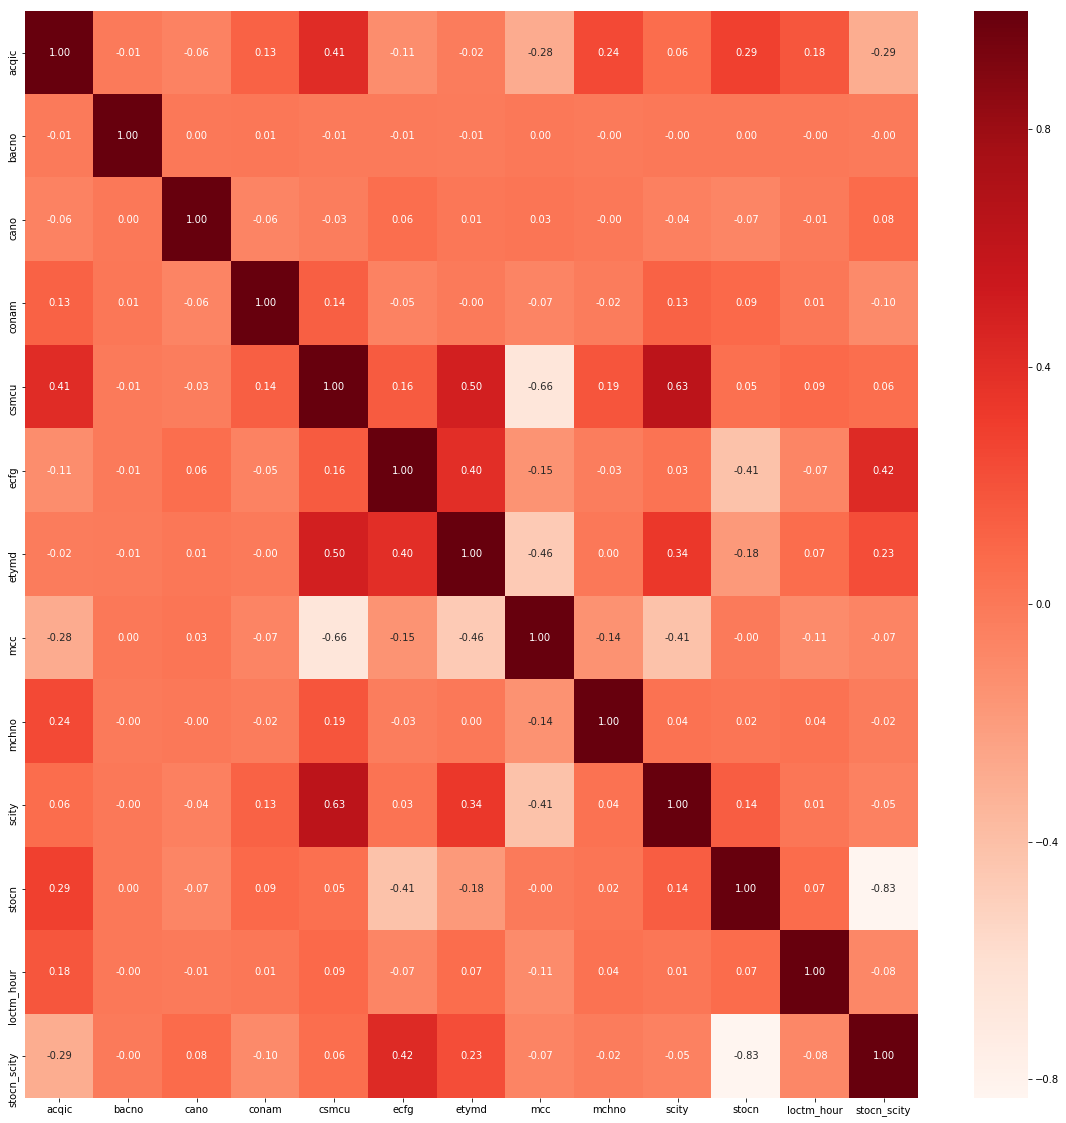

In [19]:
# 取出需要的特征
model1_features =  list(df.columns)
model1_features.remove('txkey')
model1_features.remove('locdt')
model1_features.remove('loctm')
#############################
#model1_features.remove('bacno_cano')
#model1_features.remove('flbmk')
#model1_features.remove('insfg')
#model1_features.remove('iterm')
#model1_features.remove('stscd')
#model1_features.remove('ovrlt')
model1_features.remove('loctm_s')
model1_features.remove('loctm_min')
#model1_features.remove('loctm_hour')
#model1_features.remove('conam_sqrt')

#model1_features.remove('scity_mchno_FE')
#model1_features.remove('mchno_stocn_scity_FE')
#model1_features.remove('conam_contp_FE')
#model1_features.remove('mcc_csmcu_FE')
#model1_features.remove('bacno_cano_FE')
##model1_features.remove('conam_contp_FE')
#model1_features.remove('bacno_cano_FE')
#model1_features.remove('conam_bacno_cano_mean_FE')
#model1_features.remove('conam_bacno_cano_std_FE')
#model1_features.remove('conam_bacno_cano_mean')
#model1_features.remove('conam_bacno_cano_std')
#model1_features.remove('conam_bacno_cano_std')


##########################################
model1_features.remove('fraud_ind')
X_train = df[model1_features]
Y_train = df['fraud_ind']
X_test = df_test[model1_features]
#print(model1_features)
print(X_train.shape[1])
print(X_train.columns)
show_cor(df[model1_features])

In [37]:
    params = {'max_depth': 12,
              #'gamma': 0.15626466439591735,            
              'learning_rate':0.09,
              #'min_child_weight':1.5233399970515784, 
              #'colsample_bytree':0.4,
              #'subsample':0.8,
              #'reg_alpha':4.989195734088519,
              #'reg_lambda':4.292050649851185,
              #'scale_pos_weight':73.76231884057971,
              #'eta': 0.1,
              'missing' : -100,
              'objective' :'binary:logistic',
              'tree_method':'gpu_hist',
              'eval_metric': 'auc',
             #'seed':seed,
              #'random_state ':seed,
              #'shuffle':False,
             }

In [38]:
# 将概率最大的20%作为验证集
df_validation_2 = df.iloc[int(0.8 * len(df)):, ]
df_train_2 = df.iloc[:int(0.8 * len(df)), ]

script for time consistency

In [ ]:
    import time
    tStart = time.time()#計時開始
    train_df, y_train_df = df_train_2[model1_features], df_train_2['fraud_ind']
    valid_df, y_valid_df = df_validation_2[model1_features], df_validation_2['fraud_ind']
    print('train_df.columns = ',train_df.columns)
    print('train_df.shape = ',train_df.shape)
   
    trn_data = xgb.DMatrix(train_df, label=y_train_df)
    val_data = xgb.DMatrix(valid_df, label=y_valid_df) 
   
    model = XGBClassifier(n_estimators=5000,random_state=seed,**params) 
    model.fit(train_df,y_train_df,eval_set = [(train_df,y_train_df),(valid_df,y_valid_df)],
                early_stopping_rounds = 300,verbose=10)
    pred = model.predict_proba(valid_df)[:,1]
    
    print( "      auc = ", roc_auc_score(y_valid_df, pred) ) 
    pred_file_path = 'compare_xgb.csv'
    last_pred = np.array(pd.read_csv(pred_file_path))
    print( "last  auc = ", roc_auc_score(y_valid_df, last_pred) ) 
    
    threshold = 0.5
    y_pre = [int(item>threshold) for  item in pred]  
    last_y_pre = [int(item>threshold) for  item in last_pred] 
    print( "     f1 = ", f1_score(y_valid_df, y_pre))
    print( "last f1 = ", f1_score(y_valid_df, last_y_pre))     
    print( "     average_precision = ",average_precision_score(y_valid_df, pred))
    print( "last average_precision = ",average_precision_score(y_valid_df, last_pred))

    print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )

  
    #precision_now, recall_now, thresholds_now = precision_recall_curve(y_valid_df, pred)
    #plt.figure(figsize=(10,6))
    #plt.plot(precision_now,recall_now,label="now pr ")
    #plt.xlabel('Recall',fontsize=16)
    #plt.ylabel('Precision',fontsize=16)
    #plt.ylim([0.0, 1.05])
    #plt.xlim([0.0, 1.0])
    #plt.title('2-class Precision-Recall curve: AP={0:0.5f}'.format(
    #      average_precision))   
    #plt.legend()  
   
    xgb.plot_importance(booster=model,max_num_features = 20)   
    gc.collect()
    print('_'*100)
tEnd = time.time()#計時結束
#列印結果
print ("It cost %f sec" % (tEnd - tStart))#會自動做近位
print (tEnd - tStart)#原型長這樣

train_df.columns =  Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd', 'mcc',
       'mchno', 'scity', 'stocn', 'loctm_hour', 'stocn_scity'],
      dtype='object')
train_df.shape =  (1217429, 13)
[0]	validation_0-auc:0.962946	validation_1-auc:0.959704
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.


In [41]:
 gc.collect()

303

In [29]:
pred_file_path = 'compare_xgb.csv'
last_pred = np.array(pd.read_csv(pred_file_path))
print( "last  auc = ", roc_auc_score(y_valid_df, last_pred) )  
# ROC 曲线对比
l_fpr,l_tpr,l_t = roc_curve(y_valid_df,last_pred)
fpr,tpr,t = roc_curve(y_valid_df,pred)
plt.plot(l_fpr,l_tpr,color='red',label='last best')
plt.plot(fpr,tpr,color='green',label="now")
plt.legend()  

last  auc =  0.9895314392593985


NameError: name 'pred' is not defined

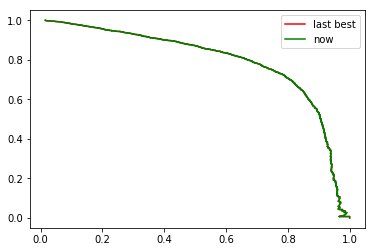

In [61]:
# PR 曲线对比
l_pr,l_re,l_t = precision_recall_curve(y_valid_df,last_pred)
pr,re,t = precision_recall_curve(y_valid_df,pred)
plt.plot(l_pr,l_re,color='red',label='last best')
plt.plot(pr,re,color='green',label="now")
plt.legend() 

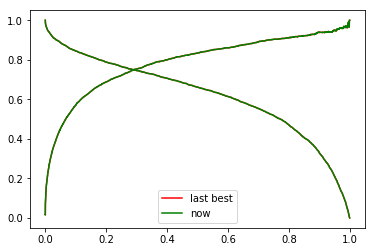

In [62]:
plt.plot(l_t,l_pr[:-1],color='red',label='last best')
plt.plot(l_t,l_re[:-1],color='red')
plt.legend() 
plt.plot(t,pr[:-1],color='green',label="now")
plt.plot(t,re[:-1],color='green')
plt.legend() 

## 是否将存为新指标

In [69]:
'''是否将存为新指标'''
print("save  file...")
last_pred = pd.DataFrame({'pred':pred})
last_pred.to_csv('compare_xgb.csv',index=None)

save  file...


  auc =  0.987349855523912
  f1 =  0.7416169039963253
  confusion_matrix = 
 [[298879   1465]
 [   785   3229]]


C:\Users\user\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\user\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


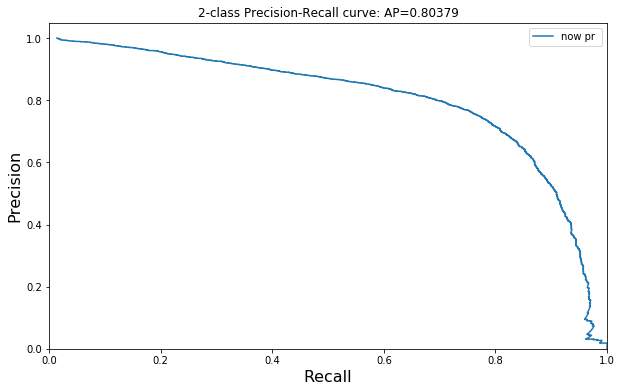

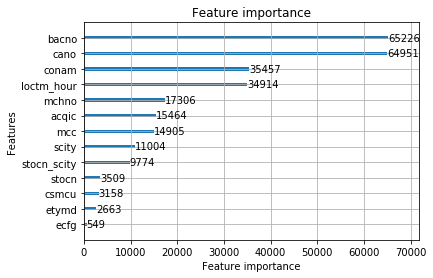

In [138]:
    #last best result stocn_scity
    print( "  auc = ", roc_auc_score(y_valid_df, pred) )    
    threshold = 0.5
    y_pre = [int(item>threshold) for  item in pred]   
    print( "  f1 = ", f1_score(y_valid_df, y_pre))
    print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )
    
    precision_now, recall_now, thresholds_now = precision_recall_curve(y_valid_df, pred)
    plt.figure(figsize=(10,6))
    plt.plot(precision_now,recall_now,label="now pr ")
    plt.xlabel('Recall',fontsize=16)
    plt.ylabel('Precision',fontsize=16)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.5f}'.format(
          average_precision))   
    plt.legend()  
    lgb.plot_importance(booster=clf,max_num_features = 20,ignore_zero =False)

  auc =  0.988060391050549
  f1 =  0.7446955719557196
  confusion_matrix = 
 [[298915   1429]
 [   785   3229]]


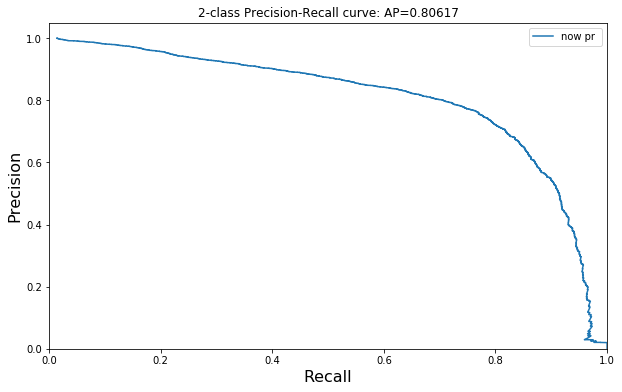

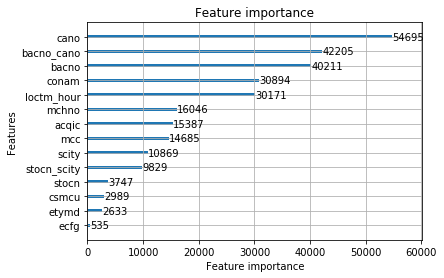

In [146]:
    #last result
    print( "  auc = ", roc_auc_score(y_valid_df, pred) )    
    threshold = 0.5
    y_pre = [int(item>threshold) for  item in pred]   
    print( "  f1 = ", f1_score(y_valid_df, y_pre))
    print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )
    
    precision_now, recall_now, thresholds_now = precision_recall_curve(y_valid_df, pred)
    plt.figure(figsize=(10,6))
    plt.plot(precision_now,recall_now,label="now pr ")
    plt.xlabel('Recall',fontsize=16)
    plt.ylabel('Precision',fontsize=16)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.5f}'.format(
          average_precision))   
    plt.legend()  
    lgb.plot_importance(booster=clf,max_num_features = 20,ignore_zero =False)

In [109]:
precision_now, recall_now, thresholds_now = precision_recall_curve(y_valid_df, pred)

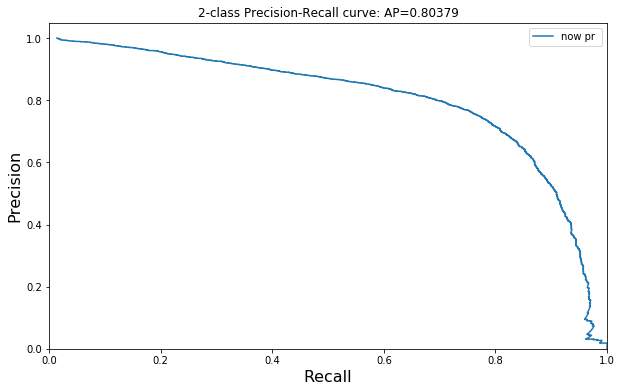

In [110]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_valid_df, pred)
from sklearn.metrics import precision_recall_curve
#precision, recall, thresholds = precision_recall_curve(y_valid_df, pred)
from inspect import signature
#plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.figure(figsize=(10,6))
#plt.fill_between(recall, precision, alpha=0.2, color='b')
#plt.plot(recall,precision,label="last pr ")
plt.plot(precision_now,recall_now,label="now pr ")
plt.xlabel('Recall',fontsize=16)
plt.ylabel('Precision',fontsize=16)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
#plt.title('2-class Precision-Recall curve',fontsize=16)
plt.title('2-class Precision-Recall curve: AP={0:0.5f}'.format(
          average_precision))
plt.legend()

In [65]:
cat_light =  list(df.columns)
cat_light.remove('fraud_ind')
cat_light.remove('txkey')
cat_light.remove('loctm')
cat_light.remove('locdt')
cat_light.remove('conam')

In [66]:
# 获取最佳 阈值方法 
def get_threshold(pre,rec,threshold):
    thold = []
    for i in range(len(threshold)):
        if round(pre[i],4)== round(rec[i],4):
            thold.append(threshold[i]) 
    return thold
pr,re,t = precision_recall_curve(Y_train,Y_valid)
#thold = get_threshold(pr,re,t)

NameError: name 'Y_valid' is not defined

In [ ]:
 import time
    tStart = time.time()#計時開始
    train_df, y_train_df = df_train_2[model1_features], df_train_2['fraud_ind']
    valid_df, y_valid_df = df_validation_2[model1_features], df_validation_2['fraud_ind']
    print('train_df.columns = ',train_df.columns)
    print('train_df.shape = ',train_df.shape)
   
    trn_data = xgb.DMatrix(train_df, label=y_train_df,missing=-100)
    val_data = xgb.DMatrix(valid_df, label=y_valid_df,missing=-100) 
    Dtrain_df = xgb.DMatrix(train_df,missing=-100)
    Dvalid_df = xgb.DMatrix(valid_df,missing=-100)
    watchlist = [(trn_data,'train'),(val_data,'val')]
    model = xgb.train(params,
                    trn_data,
                    num_boost_round= 5000,
                    evals  =watchlist,             
                    verbose_eval=100,
                    early_stopping_rounds = 200
                     )   
    pred = model.predict(Dvalid_df)  
    
    print( "      auc = ", roc_auc_score(y_valid_df, pred) ) 
    pred_file_path = 'compare.csv'
    last_pred = np.array(pd.read_csv(pred_file_path))
    print( "last  auc = ", roc_auc_score(y_valid_df, last_pred) ) 
    
    threshold = 0.5
    y_pre = [int(item>threshold) for  item in pred]  
    last_y_pre = [int(item>threshold) for  item in last_pred] 
    print( "     f1 = ", f1_score(y_valid_df, y_pre))
    print( "last f1 = ", f1_score(y_valid_df, last_y_pre))     
    print( "     average_precision = ",average_precision_score(y_valid_df, pred))
    print( "last average_precision = ",average_precision_score(y_valid_df, last_pred))

    print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )

  
    #precision_now, recall_now, thresholds_now = precision_recall_curve(y_valid_df, pred)
    #plt.figure(figsize=(10,6))
    #plt.plot(precision_now,recall_now,label="now pr ")
    #plt.xlabel('Recall',fontsize=16)
    #plt.ylabel('Precision',fontsize=16)
    #plt.ylim([0.0, 1.05])
    #plt.xlim([0.0, 1.0])
    #plt.title('2-class Precision-Recall curve: AP={0:0.5f}'.format(
    #      average_precision))   
    #plt.legend()  
   
    xgb.plot_importance(booster=model,max_num_features = 20)
    print('_'*100)
tEnd = time.time()#計時結束
#列印結果
print ("It cost %f sec" % (tEnd - tStart))#會自動做近位
print (tEnd - tStart)#原型長這樣

## train start!

train feature  Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd', 'mcc',
       'mchno', 'scity', 'stocn', 'loctm_hour', 'stocn_scity'],
      dtype='object')
____________________________________________________________________________________________________
Fold 0


C:\Users\kiwi\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-aucpr:0.430969	val-aucpr:0.376918
Multiple eval metrics have been passed: 'val-aucpr' will be used for early stopping.

Will train until val-aucpr hasn't improved in 200 rounds.
[1]	train-aucpr:0.522672	val-aucpr:0.453766


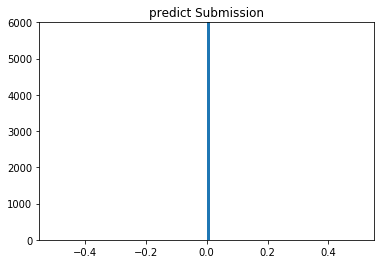

____________________________________________________________________________________________________
Fold 1


C:\Users\kiwi\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-aucpr:0.439979	val-aucpr:0.349759
Multiple eval metrics have been passed: 'val-aucpr' will be used for early stopping.

Will train until val-aucpr hasn't improved in 200 rounds.
[1]	train-aucpr:0.53594	val-aucpr:0.424949


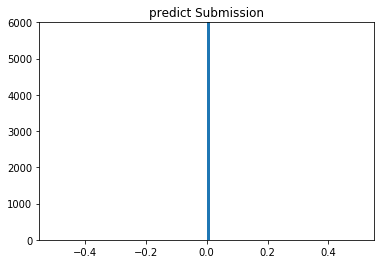

____________________________________________________________________________________________________
Fold 2


C:\Users\kiwi\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-aucpr:0.452169	val-aucpr:0.340527
Multiple eval metrics have been passed: 'val-aucpr' will be used for early stopping.

Will train until val-aucpr hasn't improved in 200 rounds.
[1]	train-aucpr:0.54123	val-aucpr:0.421399


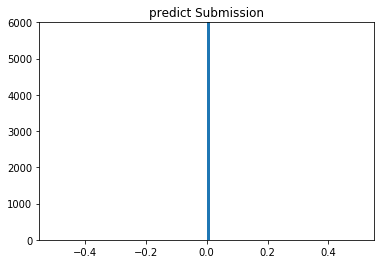

avg  auc =  0.9568123928523459
avg  f1 =  0.2756763304246142
oof  auc =  0.9570137993368365
oof  f1 =  0.2754671968190855
confusion_matrix =
[[1500101    1331]
 [  16891    3464]]
oof  average_precision =  0.43205935391326833


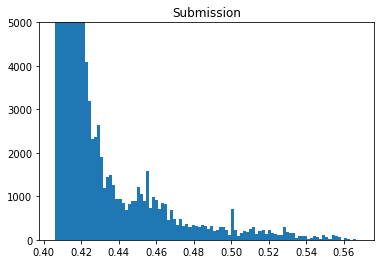

In [48]:
    #print('All feature =',X_train.columns)# script
    #for i, col  in enumerate(X_train.columns):# script
    script_features = list(X_train.columns) 
    #script_features.remove(col) # script  
    X_train_s = df[script_features]
    Y_train_s = df['fraud_ind']
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X_train_s.columns
    splits = 3
    oof = np.zeros(len(X_train))
    folds = KFold(n_splits = splits)
    folds = GroupKFold(n_splits=splits)
    ##folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=SEED)
    split_groups = df['locdt'] #group
    #split_groups = df['fraud_ind'] #startifiedkfold   
    f1_avg = 0
    auc_avg = 0
    predictions = np.zeros(len(X_test))
    #print('remove feature =',col)
    print('train feature ',X_train_s.columns)
    #for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, Y_train)): #kfold
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_s, Y_train_s,groups=split_groups)): #groupkfold and startifiedfold
        print('_'*100)
    
        print("Fold {}".format(fold_))
        
        train_df, y_train_df = X_train_s.iloc[trn_idx], Y_train_s.iloc[trn_idx]
        valid_df, y_valid_df = X_train_s.iloc[val_idx], Y_train_s.iloc[val_idx]
        
        trn_data = xgb.DMatrix(train_df, label=y_train_df,missing=-100)
        val_data = xgb.DMatrix(valid_df, label=y_valid_df,missing=-100) 
        Dtrain_df = xgb.DMatrix(train_df,missing=-100)
        Dvalid_df = xgb.DMatrix(valid_df,missing=-100)
        DX_test = xgb.DMatrix(X_test,missing=-100)
        watchlist = [(trn_data,'train'),(val_data,'val')]        
       
        
        clf = xgb.train(params,
                    trn_data,
                    num_boost_round= 2,
                    evals  =watchlist,             
                    verbose_eval=100,
                    early_stopping_rounds = 200
                     )   
        pred = clf.predict(Dvalid_df) 
        
        oof[val_idx] = pred
        #print(pred[0])
        #feature_importances['fold_{}'.format(fold_ + 1)] = clf.feature_importances_
    
        #print( "  auc = ", roc_auc_score(y_valid_df, pred) )    
        threshold = 0.5
        y_pre = [int(item>threshold) for  item in pred]   
        #print( "  f1 = ", f1_score(y_valid_df, y_pre))
        #print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )
        auc_avg+= roc_auc_score(y_valid_df, pred)
        f1_avg+=f1_score(y_valid_df, y_pre)
        
        predictions += clf.predict(DX_test) / splits
        del trn_data, val_data
        gc.collect()
   
        predictions = [int(item>threshold) for  item in predictions]    
 
        plt.hist(predictions,bins=100)
        plt.ylim((0,6000))
        plt.title('predict Submission')
        plt.show()
    print( "avg  auc = ", auc_avg/ splits )
    print( "avg  f1 = ", f1_avg/ splits)
    print( "oof  auc = ", roc_auc_score(Y_train_s, oof) )   
    oof_threshold = [int(item>0.5) for  item in oof] 
    print( "oof  f1 = ", f1_score(Y_train_s, oof_threshold))
    print( "confusion_matrix =")
    print(confusion_matrix(Y_train_s, oof_threshold))
    average_precision = average_precision_score(Y_train_s, oof) 
    print( "oof  average_precision = ",average_precision)
    plt.hist(oof,bins=100)
    plt.ylim((0,5000))
    plt.title('Submission')
    plt.show()  

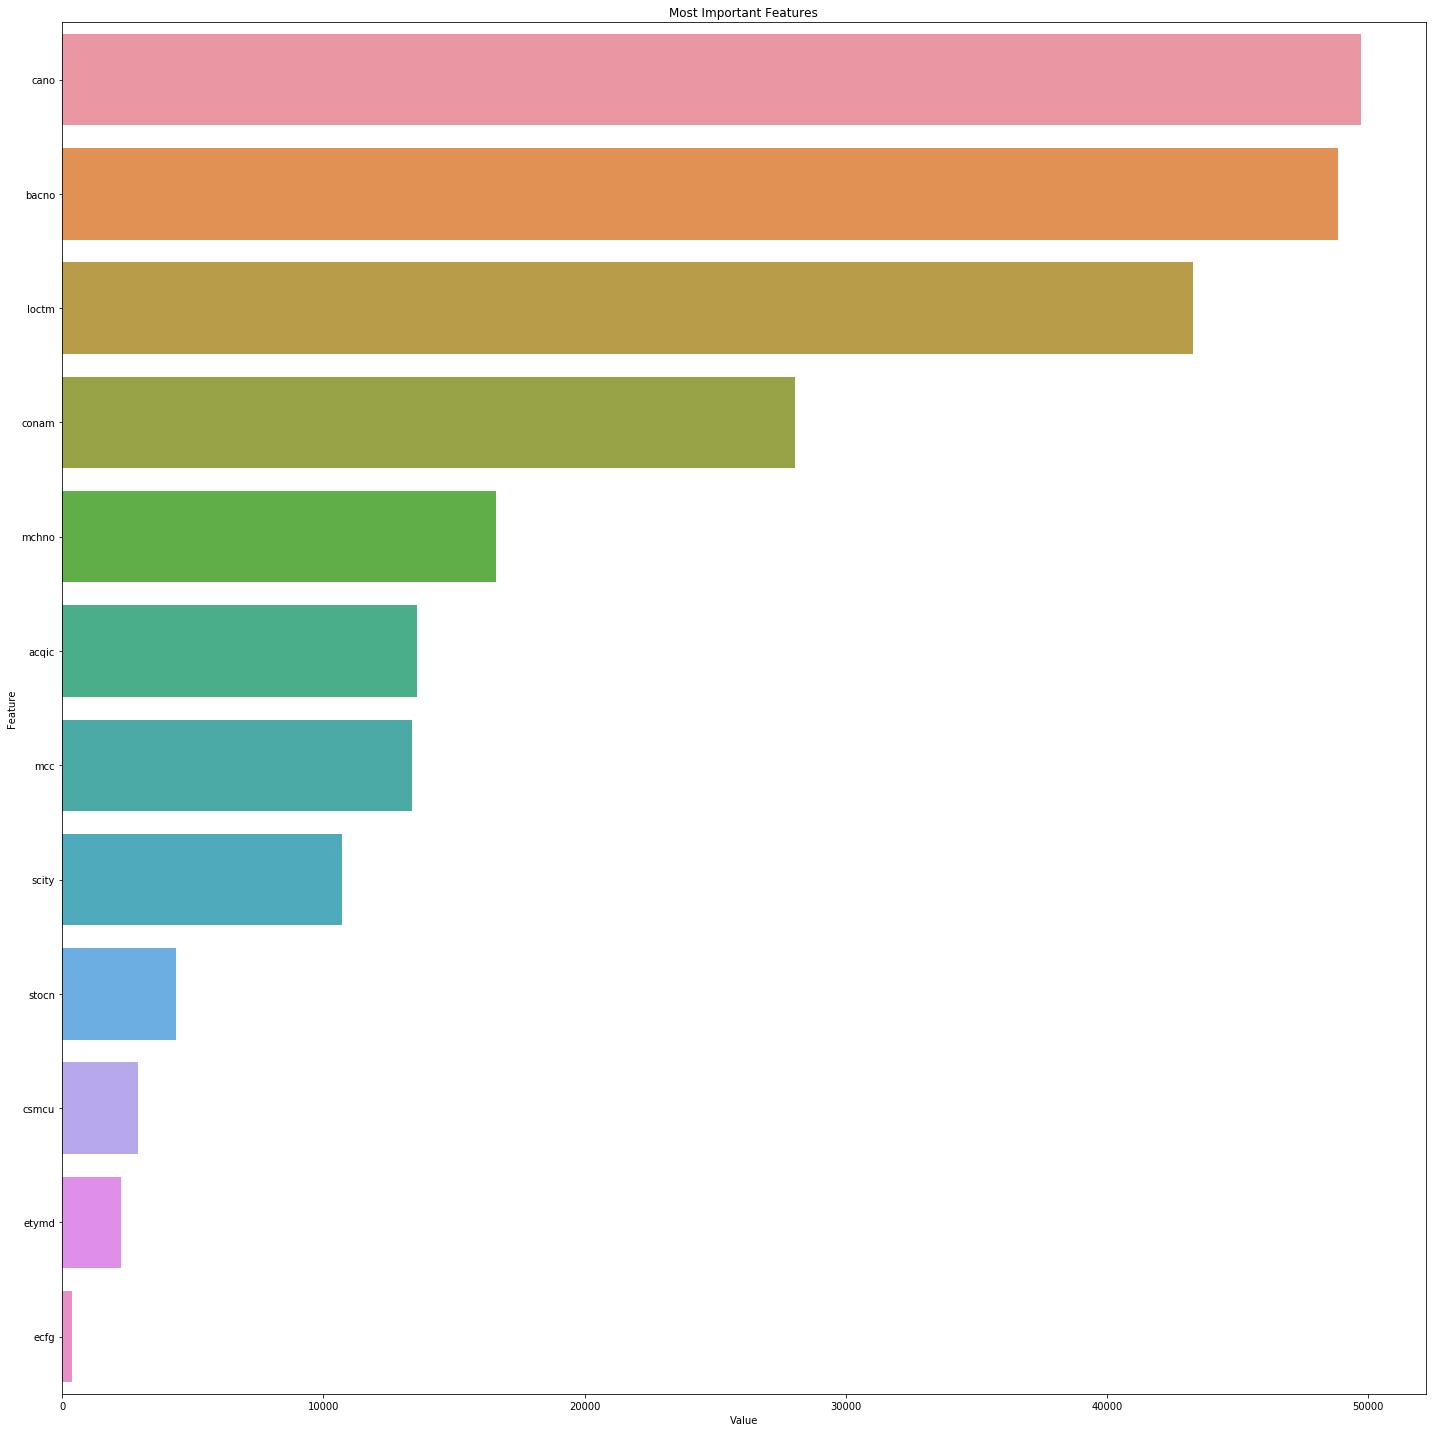

In [43]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),model1_features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:100])
plt.title('Most Important Features')
plt.tight_layout()
plt.show()

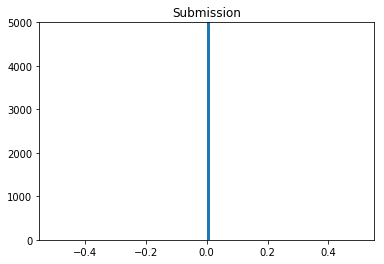

testdata = 421665
1.34% of testdata = 5650.0


KeyError: 1

In [49]:
# 结果保存
plt.hist(predictions,bins=100)
plt.ylim((0,5000))
plt.title('Submission')
plt.show()
#sampleSubmission = pd.read_csv('/content/submission_test_sample.csv')
sampleSubmission = pd.read_csv('submission_test_sample.csv')
sampleSubmission['fraud_ind'] = predictions
sampleSubmission.to_csv('submission_test.csv',index = None)

print('testdata =',df_test['txkey'].count())
print('1.34% of testdata =',round(df_test['txkey'].count()*0.0134))
print('fraud predict =',sampleSubmission['fraud_ind'].value_counts()[1])